# CleavAI

© 2025 JForCell Corporation. All Rights Reserved.

In [118]:
import warnings
from collections import Counter

import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE

from transformers import BertModel, BertTokenizer

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [119]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
warnings.filterwarnings("ignore")

### Final DataFrame

#### Feature Engineering

In [120]:
df = pd.read_csv("./all_windows.csv")

In [121]:
def extract_bio_features(seq):
    pa = ProteinAnalysis(seq)
    aa_count = pa.count_amino_acids()
    length = len(seq)
    basic = sum(aa_count.get(aa, 0) for aa in "KRH")
    acidic = sum(aa_count.get(aa, 0) for aa in "DE")
    hydrophobic = sum(aa_count.get(aa, 0) for aa in "AILMFWV")
    polar = sum(aa_count.get(aa, 0) for aa in "STNQYCH")
    return {
        "molecular_weight": pa.molecular_weight(),
        "isoelectric_point": pa.isoelectric_point(),
        "aromaticity": pa.aromaticity(),
        "instability_index": pa.instability_index(),
        "gravy": pa.gravy(),
        "flexibility_avg": sum(pa.flexibility()) / length,
        "basic_fraction": basic / length,
        "acidic_fraction": acidic / length,
        "hydrophobic_fraction": hydrophobic / length,
        "polar_fraction": polar / length,
        "net_charge": basic - acidic,
        "P1_is_R": int(seq[3] == 'R') if length > 3 else 0,
        "P4_is_R": int(seq[0] == 'R') if length > 0 else 0,
        "P2_is_KR": int(seq[2] in "KR") if length > 2 else 0,
        "has_RXKR": int("R" in seq and seq.find("R") <= length - 3 and seq[seq.find("R")+2:seq.find("R")+4] == "KR")
    }

df_bio_features = df["cleavage_window"].apply(extract_bio_features).apply(pd.Series)

#### ProtBERT Embeddings

In [122]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
bert_model = BertModel.from_pretrained("Rostlab/prot_bert").eval()
bert_model = bert_model.to(device)

def format_peptide(seq):
    return ' '.join(seq)

def get_protbert_embedding(seq):
    seq = format_peptide(seq)
    tokens = tokenizer(seq, return_tensors="pt")
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)
    with torch.no_grad():
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[0, 0, :].cpu().numpy()

embeddings = [get_protbert_embedding(seq) for seq in tqdm(df["cleavage_window"])]
df_bert = pd.DataFrame(embeddings)

100%|██████████| 3236/3236 [00:53<00:00, 60.15it/s]


#### Concat

In [123]:
df_bert.columns = df_bert.columns.astype(str)
df_bio_features.columns = df_bio_features.columns.astype(str)

df_full = pd.concat([df_bio_features.reset_index(drop=True), df_bert.reset_index(drop=True), df["label"].reset_index(drop=True)], axis=1)

X = df_full.drop("label", axis=1).astype("float32")
y = df_full["label"].astype("float32")

In [124]:
df_full.head()

,molecular_weight,isoelectric_point,aromaticity,instability_index,gravy,flexibility_avg,basic_fraction,acidic_fraction,hydrophobic_fraction,polar_fraction,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,830.9523,9.795020,0.000,77.6125,-0.3625,0.0,0.125,0.000,0.375,0.250,...,0.027726,-0.033809,-0.112222,0.000381,-0.149614,-0.102910,-0.039104,-0.059422,-0.015624,0
1,1029.2378,11.000385,0.000,73.5750,-1.6875,0.0,0.500,0.125,0.250,0.125,...,0.040532,-0.090537,-0.157128,0.056218,-0.180328,-0.132918,-0.053840,-0.035835,0.027600,0
2,884.0581,9.507749,0.000,77.0250,-1.1000,0.0,0.250,0.000,0.125,0.250,...,-0.035274,0.010787,-0.086449,0.007868,-0.219744,-0.103184,-0.061995,-0.046654,-0.003053,1
3,986.1667,8.687711,0.000,-1.8625,-1.2375,0.0,0.375,0.250,0.375,0.000,...,0.054173,0.017081,-0.119059,-0.072451,-0.126138,-0.074783,-0.041763,-0.055947,-0.019595,0
4,1089.2445,6.915680,0.375,44.6500,-0.0250,0.0,0.250,0.000,0.375,0.500,...,-0.000230,0.049908,-0.161530,0.078383,-0.210160,-0.120043,-0.092228,0.092471,0.038006,1


### Modeling

#### Train Test Split

In [125]:
X = df_full.drop("label", axis=1).astype("float32")
y = df_full["label"].astype("float32")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#### DataLoader

In [126]:
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

class BiochemBERTMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = BiochemBERTMLP(X.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [127]:
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    y_true, y_pred_prob = [], []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            y_true.extend(yb.numpy())
            preds = model(xb).squeeze().cpu().numpy()
            y_pred_prob.extend(preds)

    y_pred_bin = [1 if p > threshold else 0 for p in y_pred_prob]

    return {
        "accuracy": accuracy_score(y_true, y_pred_bin),
        "precision": precision_score(y_true, y_pred_bin),
        "recall": recall_score(y_true, y_pred_bin),
        "f1_score": f1_score(y_true, y_pred_bin)
    }

In [128]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    total_samples = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(xb)
        total_samples += len(xb)

    avg_loss = epoch_loss / total_samples
    metrics = evaluate_model(model, test_loader)

    print(f"Epoch {epoch:2d} | Loss: {avg_loss:.4f} | "
          f"Acc: {metrics['accuracy']:.3f} | "
          f"Prec: {metrics['precision']:.3f} | "
          f"Rec: {metrics['recall']:.3f} | "
          f"F1: {metrics['f1_score']:.3f}")

Epoch  1 | Loss: 0.5055 | Acc: 0.835 | Prec: 0.735 | Rec: 0.531 | F1: 0.616
Epoch  2 | Loss: 0.3599 | Acc: 0.866 | Prec: 0.778 | Rec: 0.648 | F1: 0.707
Epoch  3 | Loss: 0.2841 | Acc: 0.906 | Prec: 0.898 | Rec: 0.704 | F1: 0.789
Epoch  4 | Loss: 0.2168 | Acc: 0.894 | Prec: 0.821 | Rec: 0.735 | F1: 0.775
Epoch  5 | Loss: 0.2232 | Acc: 0.938 | Prec: 0.936 | Rec: 0.809 | F1: 0.868
Epoch  6 | Loss: 0.1881 | Acc: 0.935 | Prec: 0.929 | Rec: 0.802 | F1: 0.861
Epoch  7 | Loss: 0.1816 | Acc: 0.937 | Prec: 0.923 | Rec: 0.815 | F1: 0.866
Epoch  8 | Loss: 0.1560 | Acc: 0.929 | Prec: 0.903 | Rec: 0.802 | F1: 0.850
Epoch  9 | Loss: 0.1540 | Acc: 0.927 | Prec: 0.886 | Rec: 0.815 | F1: 0.849
Epoch 10 | Loss: 0.1428 | Acc: 0.940 | Prec: 0.902 | Rec: 0.852 | F1: 0.876


In [129]:
model.eval()
y_pred_probs = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).squeeze().cpu().numpy()
        y_pred_probs.extend(preds)
        y_true.extend(yb.numpy())

print("Prediction mean:", np.mean(y_pred_probs))
print("Prediction min/max:", np.min(y_pred_probs), np.max(y_pred_probs))

Prediction mean: 0.24351431
Prediction min/max: 1.4624492e-05 0.99997914


### Candidates

In [ ]:
AA_COST = {
    'A': 1.0,
    'C': 5.0,
    'D': 2.0,
    'E': 2.0,
    'F': 3.5,
    'G': 2.0,
    'H': 3.0,
    'I': 2.5,
    'K': 2.0,
    'L': 2.0,
    'M': 4.5,
    'N': 2.0,
    'P': 3.0,
    'Q': 2.0,
    'R': 1.5,
    'S': 1.0,
    'T': 0.8,
    'V': 2.0,
    'W': 6.0,
    'Y': 4.0
}

def peptide_cost(seq: str) -> int:
    return sum(AA_COST.get(aa, 10) for aa in seq)

def compute_efficiency(prob, cost, min_cost=5, max_cost=15, cleavage_weight=0.85, cost_weight=0.15):
    cost_norm = (cost - min_cost) / (max_cost - min_cost)
    cost_penalty = 1 - cost_norm
    cost_penalty = max(0, min(cost_penalty, 1))
    score = (cleavage_weight * prob) + (cost_weight * cost_penalty)
    return round(min(score, 1.0), 4)

In [198]:
def score_peptide(seq):
    bio = extract_bio_features(seq)
    bert = get_protbert_embedding(seq)

    combined = np.concatenate([np.array(list(bio.values()), dtype=np.float32), bert])
    combined_scaled = scaler.transform([combined])

    with torch.no_grad():
        x_tensor = torch.tensor(combined_scaled, dtype=torch.float32).to(device)
        prob = model(x_tensor).item()

    cost = peptide_cost(seq)
    efficiency = compute_efficiency(prob, cost)

    return {
        "peptide": seq,
        "cleavage_prob": prob,
        "synthesis_cost": cost,
        "efficiency": efficiency,
        **bio
    }

In [199]:
AA = "ACDEFGHIKLMNPQRSTVWY"
BASIC = "KR"
candidates = []

# R-X-[K/R]-R↓
for p3 in AA:
    for p2 in BASIC:
        for p1p in AA:
            pep = "R" + p3 + p2 + "R" + p1p
            candidates.append(pep)

In [200]:
scored_peptides = [score_peptide(p) for p in candidates]
df_candidates = pd.DataFrame(scored_peptides).sort_values("efficiency", ascending=False)

In [201]:
print(df_candidates[["peptide", "efficiency", "cleavage_prob", "synthesis_cost"]].head(20))

    peptide  efficiency  cleavage_prob  synthesis_cost
580   RRRRA      0.9655       0.994725             7.0
676   RTRRT      0.9649       0.978065             6.1
674   RTRRR      0.9648       0.990402             6.8
576   RRKRT      0.9643       0.989780             6.8
636   RSRRT      0.9640       0.980538             6.3
335   RKKRS      0.9631       0.991876             7.0
625   RSRRG      0.9621       0.999491             7.5
594   RRRRR      0.9618       0.999169             7.5
617   RSKRV      0.9602       0.997345             7.5
635   RSRRS      0.9594       0.978648             6.5
614   RSKRR      0.9582       0.986093             7.0
574   RRKRR      0.9568       0.993258             7.5
334   RKKRR      0.9560       0.992395             7.5
603   RSKRE      0.9559       0.992207             7.5
695   RVKRS      0.9556       0.991931             7.5
655   RTKRS      0.9549       0.969940             6.3
234   RGRRR      0.9547       0.999593             8.0
345   RKRR

### Plots

In [164]:
def plot_roc(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", lw=2, color="darkorange")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [165]:
def plot_pr(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ap = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="purple", lw=2, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_top_candidates(df, top_n=20, xlim_min=0.9, xlim_max=1):
    df_top = df.sort_values("efficiency", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_top,
        x="efficiency",
        y="peptide",
        palette="viridis"
    )

    for _, bar in enumerate(ax.patches):
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            width + 0.005, y,
            f"{width:.3f}",
            va="center", ha="left",
            fontsize=9, color="black"
        )

    plt.title(f"Top {top_n} Peptides Efficiency", fontsize=15, weight="semibold")
    plt.xlabel("Efficiency Score", fontsize=12)
    plt.ylabel("Peptide", fontsize=12)
    plt.xlim(xlim_min, xlim_max)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

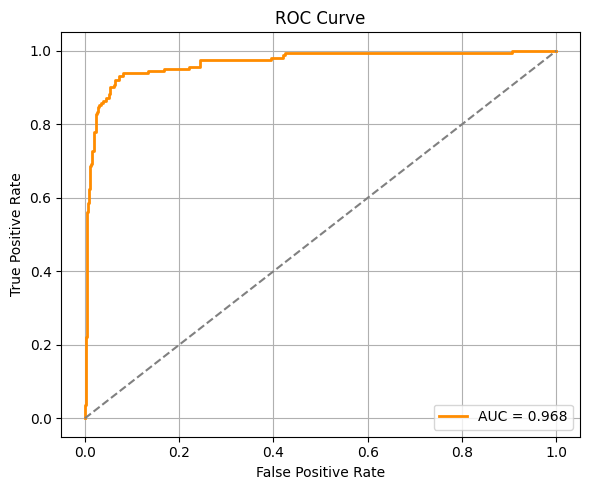

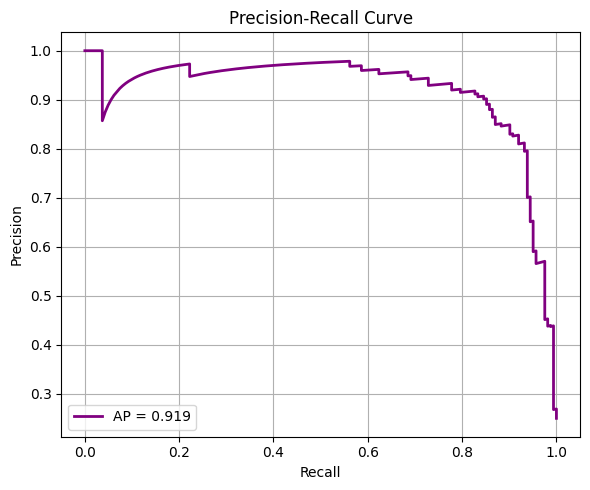

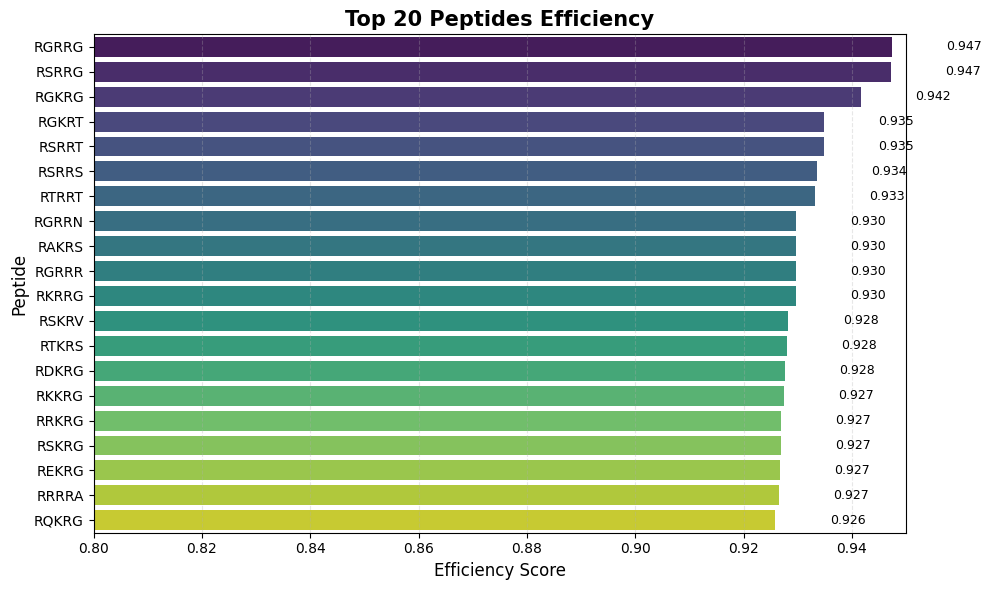

In [167]:
plot_roc(y_test, y_pred_probs)
plot_pr(y_test, y_pred_probs)
plot_top_candidates(df_candidates)
